In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd

c:\Users\jaesc2\GitHub\skforecast


# Test bike sharing

In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import (
    set_dark_theme,
    plot_residuals,
    plot_prediction_distribution,
    plot_prediction_intervals
)
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning import create_and_compile_model
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [3]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing', raw=False)
data = data[['users', 'temp', 'hum', 'windspeed', 'holiday']]
data = data.loc['2011-04-01 00:00:00':'2012-10-20 23:00:00', :].copy()
data.head(3)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,users,temp,hum,windspeed,holiday
date_time,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0


In [4]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cyclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                       variables     = features_to_encode,
                       max_values    = max_values,
                       drop_original = True
                   )

exog_transformer = make_pipeline(
                       calendar_transformer,
                       cyclical_encoder
                   )

data = exog_transformer.fit_transform(data)
exog_features = data.columns.difference(['users']).tolist()
data.head(3)

,users,temp,hum,windspeed,holiday,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.000000,1.000000
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.258819,0.965926
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.500000,0.866025


In [5]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-06-30 23:59:00'
end_validation = '2012-10-01 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-04-01 00:00:00 --- 2012-06-30 23:00:00  (n=10968)
Dates validation : 2012-07-01 00:00:00 --- 2012-10-01 23:00:00  (n=2232)
Dates test       : 2012-10-02 00:00:00 --- 2012-10-20 23:00:00  (n=456)


In [6]:
# Advance usage of `create_and_compile_model`
# ==============================================================================    
series = ['users']
levels = ['users']
lags = 72

model = create_and_compile_model(
    series                  = data[series],  # DataFrame with all series (predictors)
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 36, 
    exog                    = data[exog_features],    # Exogenous variables
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "MultiSeries-Multi-Step-Exog"
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "MultiSeries-Multi-Step-Exog"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 72, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 72, 128)   │     66,560 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 36, 64)    │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 36, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_exog         │ (None, 36, 76)    │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_1          │ (None, 36, 64)    │      4,928 │ concat_exog[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_2          │ (None, 36, 32)    │      2,080 │ dense_td_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_td_la… │ (None, 36, 1)     │         33 │ dense_td_2[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,009 (480.50 KB)

 Trainable params: 123,009 (480.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val[series],  # Validation data for model training.
        "exog_val": data_val[exog_features]  # Validation data for exogenous variables
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(series=data_train[series], exog=data_train[exog_features])

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0491 - val_loss: 0.0676 - learning_rate: 0.0010
Epoch 2/2


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0292 - val_loss: 0.0571 - learning_rate: 0.0010


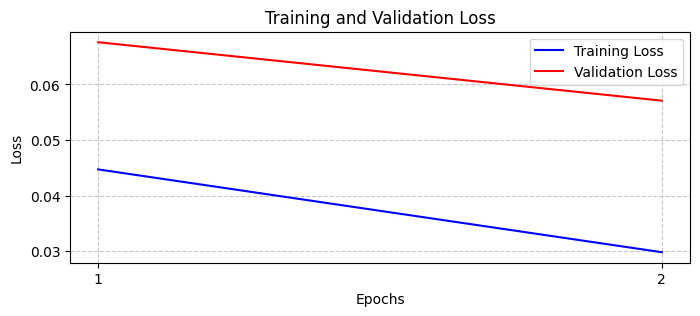

In [11]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [ ]:
# Backtesting with test data and exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics_exog, predictions_exog = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data[series],
    exog              = data[exog_features],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False,
    n_jobs            = "auto"
)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: Deprecati

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 0.0642 - val_loss: 0.0802 - learning_rate: 0.0010
Epoch 2/2


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.0361 - val_loss: 0.0536 - learning_rate: 0.0010


  0%|          | 0/13 [00:00<?, ?it/s]

In [11]:
# With exog XGboost, MAE = 49
metrics_exog

,levels,mean_absolute_error
0,users,48.644018


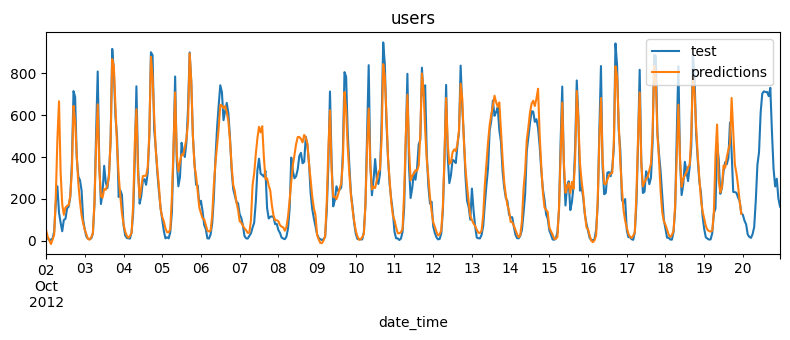

In [13]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3.5), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_exog.loc[predictions_exog["level"] == level, "pred"].plot(ax=ax, label="predictions")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()

### no exog

In [14]:
# Advance usage of `create_and_compile_model`
# ==============================================================================    
series = ['users']
levels = ['users']
lags = 72

model = create_and_compile_model(
    series                  = data[series],  # DataFrame with all series (predictors)
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 36, 
    # exog                    = data[exog_features],    # Exogenous variables
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "MultiSeries-Multi-Step-Exog"
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "MultiSeries-Multi-Step-Exog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 72, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 36)             │         1,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 36, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,396 (482.02 KB)

 Trainable params: 123,396 (482.02 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val[series],  # Validation data for model training.
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(series=data_train[series])

Epoch 1/100


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 0.0464 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 2/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0208

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0178 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0128 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0121 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0116 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0112 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0110 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0107 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0103 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0099 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 11/1

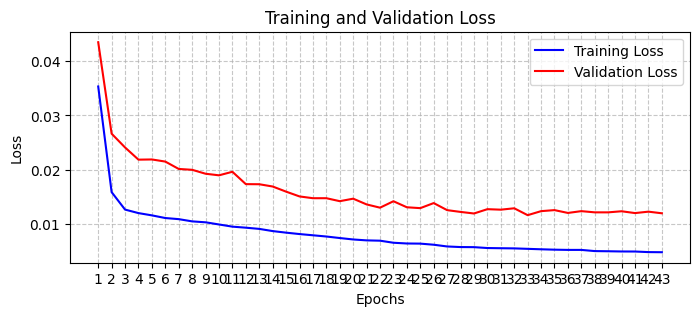

In [16]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [ ]:
# Backtesting with test data and exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics_no_exog_old_func, predictions_no_exog_old_func = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data[series],
    # exog              = data[exog_features],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False
)

Epoch 1/100


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.0059 - val_loss: 0.0092 - learning_rate: 1.2500e-04
Epoch 2/100
  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.0050

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.0058 - val_loss: 0.0092 - learning_rate: 1.2500e-04
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0058 - val_loss: 0.0087 - learning_rate: 1.2500e-04
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0056 - val_loss: 0.0085 - learning_rate: 1.2500e-04
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.0056 - val_loss: 0.0084 - learning_rate: 1.2500e-04
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.0056 - val_loss: 0.0083 - learning_rate: 1.2500e-04
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.0055 - val_loss: 0.0085 - learning_rate: 1.2500e-04
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0055 - val_loss: 0.0081 - learning_rate: 1.2500e-04
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0055 - val_loss: 0.0081 - learning_rate: 1.2500e-04
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0

  0%|          | 0/12 [00:00<?, ?it/s]

In [18]:
# With exog XGboost, MAE = 76
metrics_no_exog_old_func

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):


,levels,mean_absolute_error
0,users,68.159972


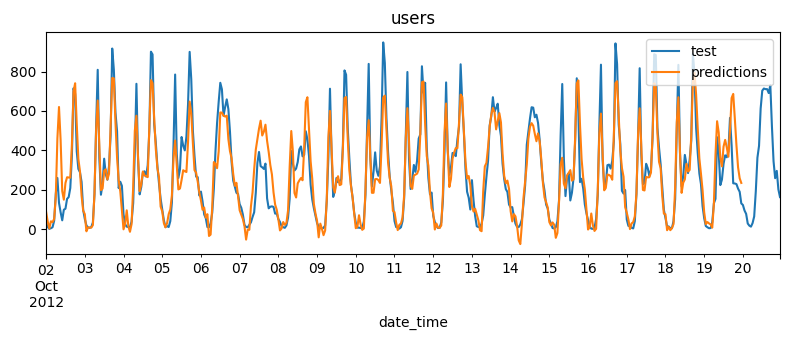

In [19]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3.5), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_no_exog_old_func.loc[predictions_no_exog_old_func["level"] == level, "pred"].plot(ax=ax, label="predictions")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()

### No exog but with compile_exog

In [ ]:
# Advance usage of `create_and_compile_model`
# ============================================================================== 
from skforecast.deep_learning.utils import _create_and_compile_model_exog
   
series = ['users']
levels = ['users']
lags = 72

model = _create_and_compile_model_exog(
    series                  = data[series],  # DataFrame with all series (predictors)
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 36, 
    # exog                    = data[exog_features],    # Exogenous variables
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "MultiSeries-Multi-Step-Exog"
)

model.summary()

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):


ValueError: `TimeDistributed` Layer should be passed an `input_shape` with at least 3 dimensions, received: (None, 64)

In [21]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val[series],  # Validation data for model training.
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(series=data_train[series])

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - loss: 0.0345 - val_loss: 0.0627 - learning_rate: 0.0010
Epoch 2/100
 1/85 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.0263

c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - loss: 0.0281 - val_loss: 0.0588 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 315ms/step - loss: 0.0279 - val_loss: 0.0592 - learning_rate: 0.0010
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - loss: 0.0277 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 0.0279 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0277 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 392ms/step - loss: 0.0278 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0275
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - loss: 0.0275 - val_loss: 0.0587 - learning_rate: 0.0010
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - loss: 0.0277 - val_loss: 0.0586 - learni

KeyboardInterrupt: 

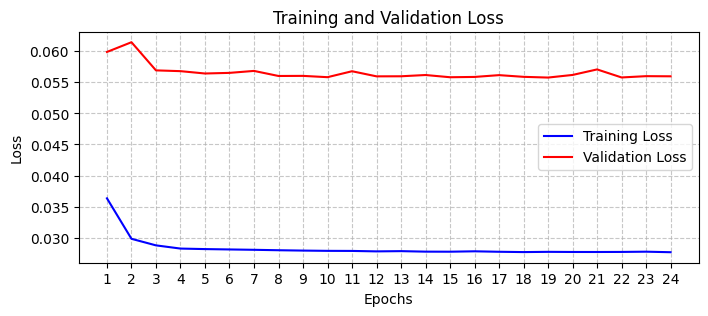

In [ ]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [ ]:
# Backtesting with test data and exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
         steps                 = forecaster.max_step,
         initial_train_size    = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit                 = False,
         allow_incomplete_fold = False
     )

metrics_no_exog_new_func, predictions_no_exog_new_func = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data[series],
    # exog              = data[exog_features],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False
)

Epoch 1/50


c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - loss: 0.0313 - val_loss: 0.0559
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - loss: 0.0314 - val_loss: 0.0557
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - loss: 0.0314 - val_loss: 0.0558
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - loss: 0.0314 - val_loss: 0.0557
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - loss: 0.0312 - val_loss: 0.0558
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - loss: 0.0314 - val_loss: 0.0557
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - loss: 0.0314 - val_loss: 0.0556
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - loss: 0.0314 - val_loss: 0.0557
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - loss: 0.0314 - val_loss: 0.0556
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - loss: 0.0315 - val_loss: 0.0565
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - loss: 0.0313 - val_loss: 0.0556
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/ste

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
# With exog XGboost, MAE = 76
metrics_no_exog_new_func

,levels,mean_absolute_error
0,users,190.754844


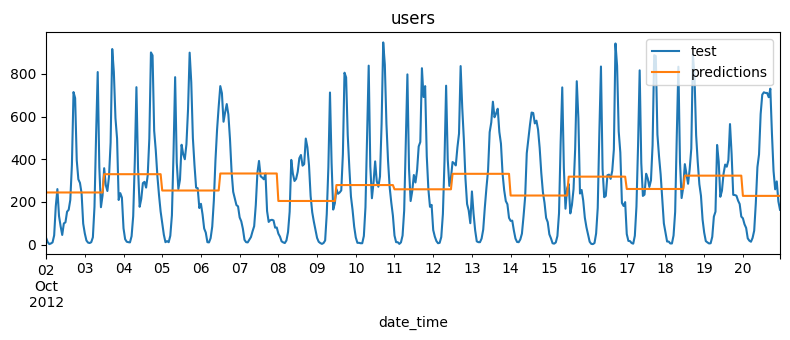

In [ ]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3.5), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_no_exog_new_func.loc[predictions_no_exog_new_func["level"] == level, "pred"].plot(ax=ax, label="predictions")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
pd.concat(
    [
        metrics_exog.rename(columns={"mean_absolute_error": "exog"}),
        metrics_no_exog_old_func.rename(
            columns={"mean_absolute_error": "no_exog_old_func"}
        ),
        metrics_no_exog_new_func.rename(
            columns={"mean_absolute_error": "no_exog_new_func"}
        ),
    ],
    axis=1,
)

NameError: name 'metrics_no_exog_old_func' is not defined

NameError: name 'predictions_exog' is not defined

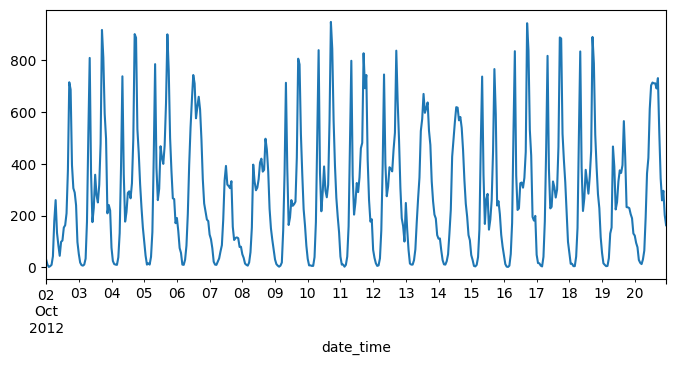

In [ ]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3.5), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax, label="test")
    predictions_exog.loc[predictions_exog["level"] == level, "pred"].plot(ax=ax, label="predictions")
    predictions_no_exog_old_func.loc[predictions_no_exog_old_func["level"] == level, "pred"].plot(ax=ax, label="predictions")
    predictions_no_exog_new_func.loc[predictions_no_exog_new_func["level"] == level, "pred"].plot(ax=ax, label="predictions")
    ax.set_title(level)
    ax.legend()

plt.tight_layout()
plt.show()